In [1]:
import os
import glob
import grizli
import grizli.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm


In [2]:
# Spectra tools
import pysynphot as S
import webbpsf

/Users/ross.1333/anaconda3/envs/grizli39/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/ross.1333/pysyn_cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/ross.1333/anaconda3/envs/grizli39/lib/python3.9/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ross.1333/pysyn_cdbs/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/ross.1333/anaconda3/envs/grizli39/lib/python3.9/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ross.1333/pysyn_cdbs/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [3]:
roman_base_dir = os.getenv('HOME')+'/Dropbox/RomanGRS/products/'
direct_fits = roman_base_dir+"FOV0/roll_0/dither_0x_0y/SCA1/GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
ready_fits = roman_base_dir+"FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
empty_seg = roman_base_dir+"FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits"

In [4]:
file = fits.open(direct_fits)

#commented out rotation
#file[1].data = np.rot90(file[1].data, k=3) # np.rot90 rotates clockwise k times

file[0].header["INSTRUME"] = "ROMAN"
file[0].header["FILTER"] = "d1_"
file[1].header["CONFFILE"] = roman_base_dir+"configuration/Roman.det1.07242020.conf" # This had to be a path, not just a filename; otherwise, grizli can't find the sensitivity fits

file.writeto(ready_fits, overwrite=True)

header = file[1].header # We need to copy this header info into the segmentation file

file.close()

In [5]:
hlss_tbl = Table.read(roman_base_dir+"FOV0/roll_0/dither_0x_0y/SCA1/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt", format="ascii")

In [6]:
SED_dir = roman_base_dir+"FOV0/SEDs/" # Change to your path to directory containing SEDs

# Create F158 Filter Bandpass object
df = Table.read(os.path.join(SED_dir, "wfirst_wfi_f158_001_syn.fits"), format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])


In [7]:
from grizli.model import GrismFLT

pad = 100 # Objects near the edge of the detector may have a trace with a center of the detector. Padding ensures it will still disperse
roman = GrismFLT(direct_file=ready_fits, seg_file=empty_seg, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


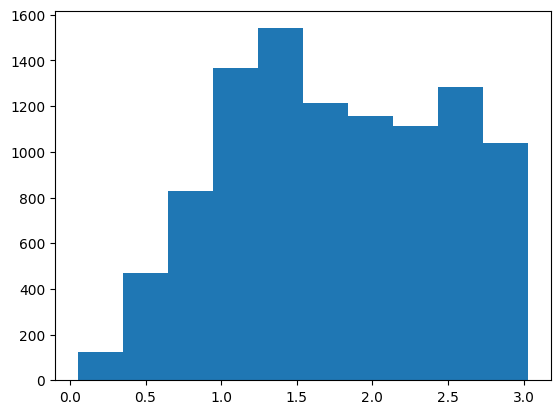

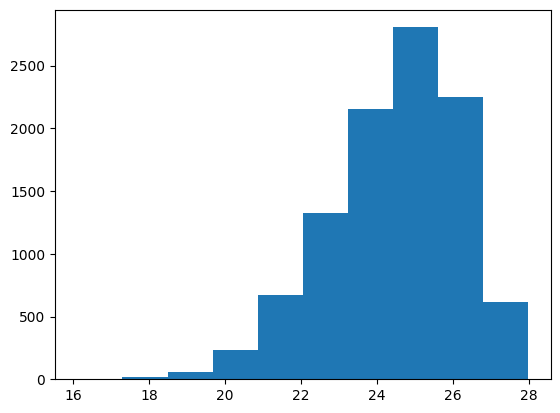

In [16]:
#look at distributions in magnitude and redshift
sel_gal = hlss_tbl["MODIMAGE"] == 0
plt.hist(hlss_tbl[sel_gal]['Z'])
plt.show()
plt.hist(hlss_tbl[sel_gal]['MAG_F1500W'])
plt.show()

In [20]:
# GALAXY generic ellipse shape
A = lambda theta, a, b: ((np.sin(theta)**2)/(a**2)) + ((np.cos(theta)**2)/(b**2))
B = lambda theta, a, b: 2 * np.sin(theta) * np.cos(theta) * ((1/b**2) - (1/a**2))
C = lambda theta, a, b: ((np.sin(theta)**2)/(b**2)) + ((np.cos(theta)**2)/(a**2))

gen_ellipse = lambda x, y, x_0, y_0, ell: (A(*ell) * (x - x_0)**2) + (B(*ell) * (x - x_0) * (y - y_0)) + (C(*ell) * (y - y_0)**2)


In [28]:
def get1d_spec(image,minl=1e4,maxl=2e4,res=25,minx=-400,maxx=599):
    #~12 angstroms per pixel
    nbin = int((maxl-minl)*1.0001/res)
    fluxl = np.zeros(nbin)
    npixl = np.zeros(nbin)
    segv = image.seg.nonzero()
    lamvl = np.arange(minl+res/2.,maxl,res)
    for i in range(0,len(segv[0])):
        xp = segv[1][i]
        yp = segv[0][i]
        #print(xp,yp)
        for dx1 in range(minx,maxx):
            dx = (dx1,dx1+1)
            dy, lam = image.conf.get_beam_trace(x=xp-image.pad, y=yp-image.pad, dx=dx, beam='A')
            #print(dx1,dy,lam)
            for lamv,dyv,dxv in zip(lam,dy,dx):
                #print(lamv,dyv,dxv)
                if lamv > minl and lamv < maxl:
                    ypf = int(yp+dyv)
                    xpf = int(xp+dxv)
                    if ypf < len(image.model[0]) and xpf < len(image.model[0]):
                        modv = image.model[ypf][xpf]
                        binv = int((lamv-minl)/res)
                        fluxl[binv] += modv
                        npixl[binv] += 1.
                        #print(lamv,modv,ypf,xpf)
                    #else:
                    #    print(segv,ypf,xpf)
    return lamvl,fluxl,npixl

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/empty_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
/Users/ross.1333/Dropbox/RomanGRS/products/FOV0/roll_0/dither_0x_0y/SCA1/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation /Users/ross.1333/Dropbox/Ro

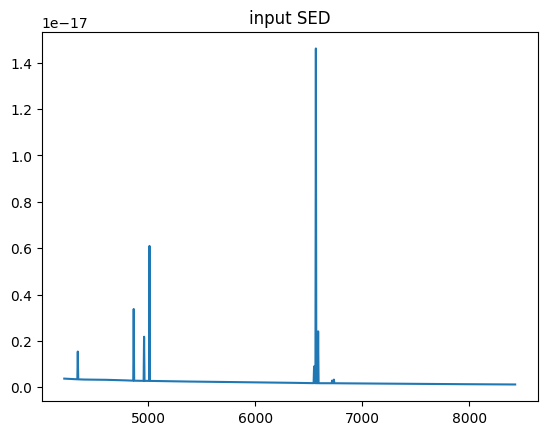

wavelength for dx = 0 is 22361.611; -600 is 22361.611; 400 is 11461.72


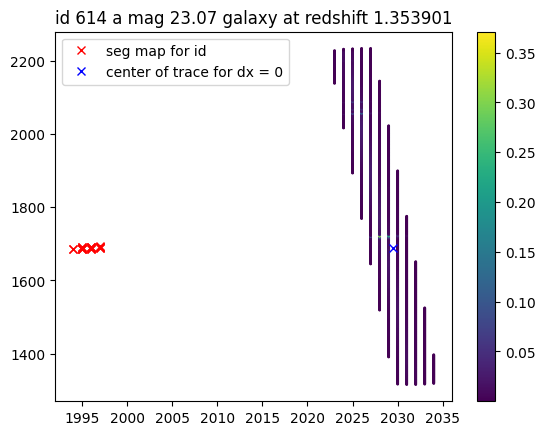

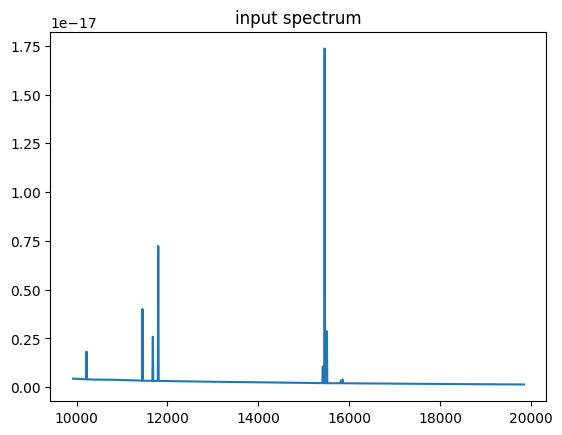

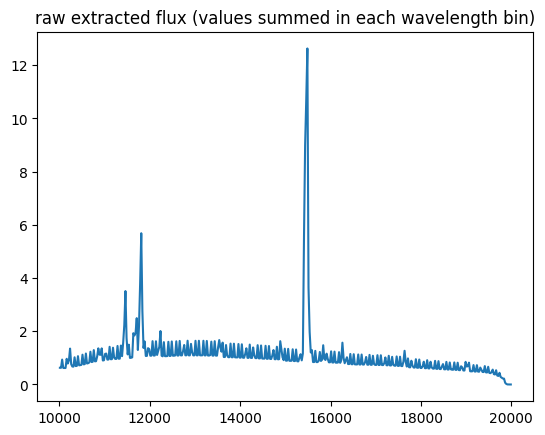

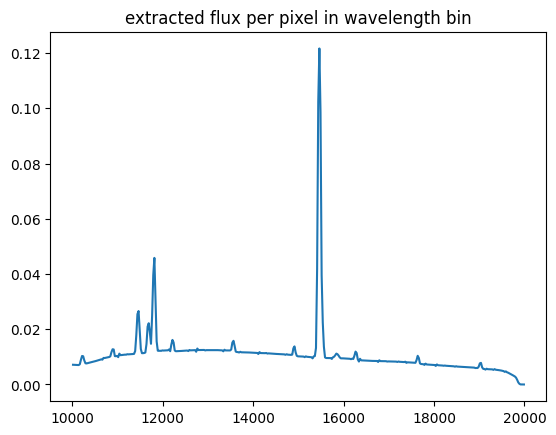

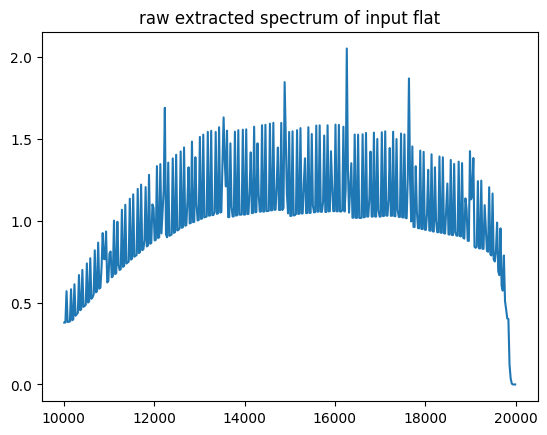

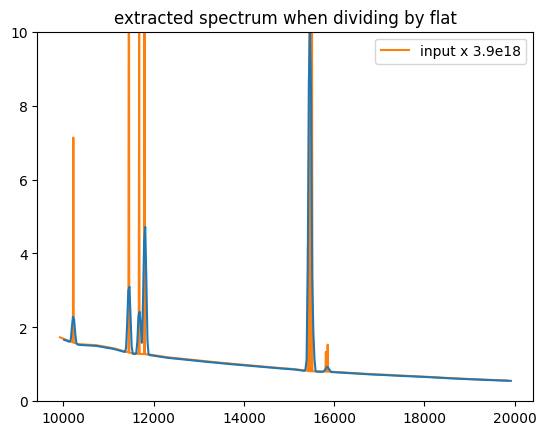

In [46]:
#get first galaxy between 23rd and 24th magnitude, create grism image, extract spectrum
N = 0
file = fits.open(direct_fits)
for row in hlss_tbl:
    if row["MODIMAGE"] == 0 and row["MAG_F1500W"] > 23 and row["MAG_F1500W"] < 24 and row['Z'] > 1 and row['Z'] < 2:
        roman_temp = GrismFLT(direct_file=ready_fits, seg_file=empty_seg, pad=pad)
        roman_flat = GrismFLT(direct_file=ready_fits, seg_file=empty_seg, pad=pad)
        temp_seg = np.zeros((4288,4288), dtype="float32") # Grizli expects arrays to have dtype="float32"

        id = row["NUMBER"]
        mag = row["MAG_F1500W"]
        x_0 = row["X_IMAGE"] + 100 # Add 100 to account for padding
        y_0 = row["Y_IMAGE"] + 100 

        a = row["A_IMAGE"] # semi-major axis
        b = row["B_IMAGE"] # semi-minor axis
        theta = row["THETA_IMAGE"] * (np.pi / 180) # theta in radians
        ell = (theta, a, b)

        # Set radius and specific ellipse shape (radius isn't the right word, but it's effectively the same)
        radius = 4
        ellipse = lambda x, y: gen_ellipse(x, y, x_0, y_0, ell) <= (radius ** 2)

        # Define cutout bounds
        x_min = max(int(x_0 - (radius * a) + 1), 0)     # Very similar to above cutout method; (radius * a) give the largest possible dimension
        x_max = min(int(x_0 + (radius * a) + 1), 4288)
        y_min = max(int(y_0 - (radius * a) + 1), 0)
        y_max = min(int(y_0 + (radius * a) + 1), 4288)

        # Create Meshgrid within bounds
        x = np.arange(x_min, x_max)
        y = np.arange(y_min, y_max)
        x_grid, y_grid = np.meshgrid(x, y)

        condition = ellipse(x_grid, y_grid)

    
        temp_seg[y_min:y_max, x_min:x_max][np.where(condition)] = id #

        roman_temp.seg = temp_seg#np.rot90(temp_seg, k=3) # temp_seg is built using non-rotated coordinates; rotate temp_seg so it lines up with our rotated direct image
        roman_flat.seg = temp_seg
        # SIMULATION

        # Read in unique Galaxy Spectrum
        sed_path = os.path.join(SED_dir, "SED:rest:gal.{0}.fits".format(row["SPECTEMP"]))
        spectrum = Table.read(sed_path, format="fits")
        wave = spectrum["wavelength"]
        flux = spectrum["flux"]
        input_flux = flux
        plt.plot(wave,flux)
        plt.title('input SED')
        plt.show()
        z = row["Z"]

        spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstrom", fluxunits="flam").redshift(z)
        spec = spec.renorm(mag, "abmag", bp)
        spec.convert("flam")
        tp = 'galaxy'
        # By default, grizli tries to compute a cutout size. This cutout size is not large enough for the roman grism.
        # In 4) FOV0_sims/notebooks/dy-by-optimize.ipynb, Keith estimates the maximum needed size to be 77 for detector 1.
        # See that notebook for more details
        roman_temp.compute_model_orders(id=id, mag=mag, compute_size=False, size=77, in_place=True, store=False,
                           is_cgs=True, spectrum_1d=[spec.wave, spec.flux])
        #roman_temp.compute_full_model(ids=[id], mags=[mag], verbose=True)
        #compute_full_model
        sel = roman_temp.model > 0
        #plt.plot(roman_temp.model.nonzero()[0],roman_temp.model.nonzero()[1],'k,')
        plt.scatter(roman_temp.model.nonzero()[0],roman_temp.model.nonzero()[1],c=roman_temp.model[sel],s=1)
        plt.colorbar()
        plt.plot(roman_temp.seg.nonzero()[0],roman_temp.seg.nonzero()[1],'rx',label='seg map for id')
        dx = (0,0)
        dy, lam = roman_temp.conf.get_beam_trace(x=x_0-roman_temp.pad, y=y_0-roman_temp.pad, dx=dx, beam='A')
        plt.plot(y_0+dy[0],x_0,'bx',label='center of trace for dx = 0')
        dx = (-600,400)
        dy, lam = roman_temp.conf.get_beam_trace(x=x_0-roman_temp.pad, y=y_0-roman_temp.pad, dx=dx, beam='A')
    
        print('wavelength for dx = 0 is '+str(round(lam[0],3))+'; -600 is '+str(round(lam[0],3))+'; 400 is '+str(round(lam[1],3)))
        titl = 'id '+str(id)+' a mag '+str(round(mag,3))+' '+tp+ ' at redshift '+str(row['Z'])
        plt.title(titl)
        plt.legend()
        #plt.plot(y_0,x_0,'rx')
        plt.show()
        plt.plot(spec.wave, spec.flux)
        plt.title('input spectrum')
        plt.show()
        lamv,flux,pix = get1d_spec(roman_temp)
        plt.plot(lamv,flux)
        plt.title('raw extracted flux (values summed in each wavelength bin)')
        plt.show()
        plt.plot(lamv,flux/pix)
        plt.title('extracted flux per pixel in wavelength bin')
        plt.show()

        flatflux = np.ones(len(wave))
        flatspec = S.ArraySpectrum(wave=wave, flux=flatflux, waveunits="angstrom", fluxunits="flam").redshift(z)
        flatspec = flatspec.renorm(mag, "abmag", bp)
        flatspec.convert("flam")
        roman_flat.compute_model_orders(id=id, mag=mag, compute_size=False, size=77, in_place=True, store=False,
                                   is_cgs=True, spectrum_1d=[flatspec.wave, flatspec.flux])
        _,flatflux,flatpix = get1d_spec(roman_flat)
        
        plt.plot(lamv,flatflux)#/flatpix)
        plt.title('raw extracted spectrum of input flat')
        plt.show()
        plt.plot(lamv,flux/flatflux)
        plt.plot(spec.wave, spec.flux*3.9e18,label='input x 3.9e18',zorder=0)
        #plt.plot(wave, input_flux,label='input flux',zorder=0)
        plt.title('extracted spectrum when dividing by flat')
        plt.legend()
        plt.ylim(0,10)
        plt.show()        
        #plt.imshow(file[1].data[int(xmin):int(xmax), int(ymin):int(ymax)],vmax=.5)
        #plt.show()

        N += 1
    if N >0:
        break

In [31]:
roman_copy = np.copy(roman_temp)

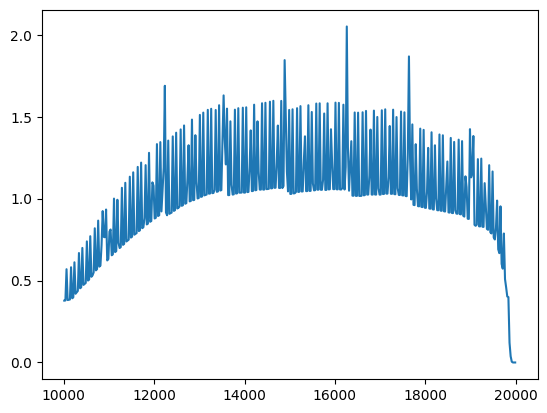

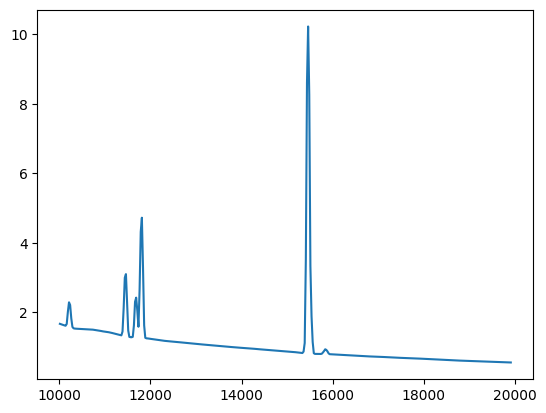

In [37]:
flatflux = np.ones(len(wave))
flatspec = S.ArraySpectrum(wave=wave, flux=flatflux, waveunits="angstrom", fluxunits="flam").redshift(z)
flatspec = flatspec.renorm(mag, "abmag", bp)
flatspec.convert("flam")
roman_flat.compute_model_orders(id=id, mag=mag, compute_size=False, size=77, in_place=True, store=False,
                           is_cgs=True, spectrum_1d=[flatspec.wave, flatspec.flux])
_,flatflux,flatpix = get1d_spec(roman_flat)
plt.plot(lamv,flatflux)#/flatpix)
plt.show()
plt.plot(lamv,flux/flatflux)
plt.show()

In [36]:
wave

4215.000001433099
4219.2150014345325
4223.430001435965
4227.645001437399
4231.860001438831
4236.075001440265
4240.290001441697
4244.505001443131
4248.720001444563
4252.935001445997
4257.15000144743
